# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) Exercise Segmentation

In this exercise, we investigate segmentation of images based on different tasks on different datasets. Your task is

- to implement different upsampling strategies for the decoder in an encoder-decoder architecture.
- to train small decoder networks with a weighted (binary-)cross-entropy loss on different datasets based on a weighting strategy of your choice.
- to implement k-Means Clustering on patch-embeddings for unsupervised image segmentation.

## Setup

### Download and extract project data to your Google Drive

1.   **Required**: Please follow all instructions of exercise 0 before running this notebook.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/g/cv3dst/cv3dst_segmentation_exercise.zip) zip file to your desktop, extract it and upload it into the `Colab Notebooks` folder in your Google Drive.



```
# This is formatted as code
```

#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


We're unzipping the dataset to the colab disk.

In [ ]:
!unzip "gdrive/My Drive/Colab Notebooks/cv3dst_segmentation_exercise/data.zip" -d "gdrive/My Drive/Colab Notebooks/cv3dst_segmentation_exercise/data"

Archive:  gdrive/My Drive/Colab Notebooks/cv3dst_segmentation_exercise/data.zip
replace gdrive/My Drive/Colab Notebooks/cv3dst_segmentation_exercise/data/object_segmentation/test_seqs.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

The `root_dir` path points to the directory and the content in your Google Drive. Also creates a syslink to the folder to allow for the ls command in the next cells.

In [2]:
!ln -s "/content/gdrive/My Drive/Colab Notebooks/cv3dst_segmentation_exercise/" "/content/cv3dst_segmentation_exercise"
segmentation_root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_segmentation_exercise/"
syslink_root_dir = "/content/cv3dst_segmentation_exercise/"

You should see the following output

```
cv3dst_segmentation_exercise  data  data.zip  models  output  src
object_segmentation  semantic_segmentation
metrics.py			 __pycache__			   utils.py
object_segementation_dataset.py  semantic_segmentation_dataset.py
evaluate_core_methods.py  evaluation.py  metrics.py  __pycache__
```

In [3]:
!ls $syslink_root_dir
!ls {syslink_root_dir+"data/"}
!ls {syslink_root_dir+"src/segmentation"}
!ls {syslink_root_dir+"src/evaluation"}

cv3dst_segmentation_exercise  data  data.zip  models  output  src
object_segmentation  semantic_segmentation
metrics.py			 __pycache__			   utils.py
object_segementation_dataset.py  semantic_segmentation_dataset.py
evaluate_core_methods.py  evaluation.py  metrics.py  __pycache__


#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import os
import sys
import copy
sys.path.append(segmentation_root_dir)

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip
!pip install -U scikit-learn scipy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp38-cp38-linux_x86_64.whl size=1619807 sha256=d856619fc2510fd20e8741c74563c6c2781dd52aca1311b923dc7cbf87a1e472
  Stored in directory: /root/.cache/pip/wheels/86/ec/8a/2baa6fb3ea3a3bdc40a9c2c4b8957b5b544f207531f7a78a89
Successfully built lap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 148.7 kB 291.9 kB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for motmetrics: filename=motmetrics-1.1.3-py3-none-any.whl size=134196 sha256=d366dec4b2764fb157630eb44e55edd8febe1b10f0190da614a6ee20b2dd0c31
  Stored in directory: /tmp/pip-ephem-wheel-cache-7mz1z__s/wheels/ed/d8/67/5ec51b9b586679a5db9d1c943ec461fc42d9e2c0aeb82c86dd
Successfully built motmetrics
Looki

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm
from typing import Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from src.segmentation.object_segementation_dataset import ObjectSegmentationDataset
from src.segmentation.semantic_segmentation_dataset import SemanticSegmentationDataset
from src.segmentation.utils import logits_to_labels, binary_output_to_labels, labels_to_color, metrics_header, print_metrics
from src.segmentation.metrics import confusion_matrix, accuracy, mean_precision, mean_recall, mean_iou

<ipython-input-5-c299a7712672>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Object segmentation dataset

The DAVIS (Densely Annotated VIdeo Segmentation) dataset provides several video sequences with highly accurate segmentation masks. In this exercise, we use the DAVIS 2016 dataset with a single instance annotation per sequence. For the task 

See the [webpage](https://davischallenge.org/davis2016/browse.html) for video sequences with ground truth annotation.

In the following, we show examples for different video sequences with their respective ground truth annotations.

You should see the following output
```
Annotations	    JPEGImages	    unsupervised_0_seqs.txt
FeatureMaps	    test_seqs.txt   unsupervised_1_seqs.txt
HoldoutAnnotations  train_seqs.txt  val_seqs.txt
FeatureMaps  ReducedAnnotations      test_seqs.txt   val_seqs.txt
Images	     reduced_class_dict.csv  train_seqs.txt
```

In [6]:
!ls {syslink_root_dir+"data/object_segmentation"}
!ls {syslink_root_dir+"data/semantic_segmentation"}

Annotations  test_seqs.txt	      unsupervised_1_seqs.txt
FeatureMaps  train_seqs.txt	      unsupervised_2_seqs.txt
JPEGImages   unsupervised_0_seqs.txt  val_seqs.txt
FeatureMaps  ReducedAnnotations      test_seqs.txt   val_seqs.txt
Images	     reduced_class_dict.csv  train_seqs.txt


In [7]:
segmentation_root_dir = Path(segmentation_root_dir)
data_dir_obj_seg = segmentation_root_dir.joinpath('data', 'object_segmentation')
data_dir_sem_seg = segmentation_root_dir.joinpath('data', 'semantic_segmentation')
model_dir =  segmentation_root_dir.joinpath('models')
output_dir = segmentation_root_dir.joinpath('output')

## Example sequences

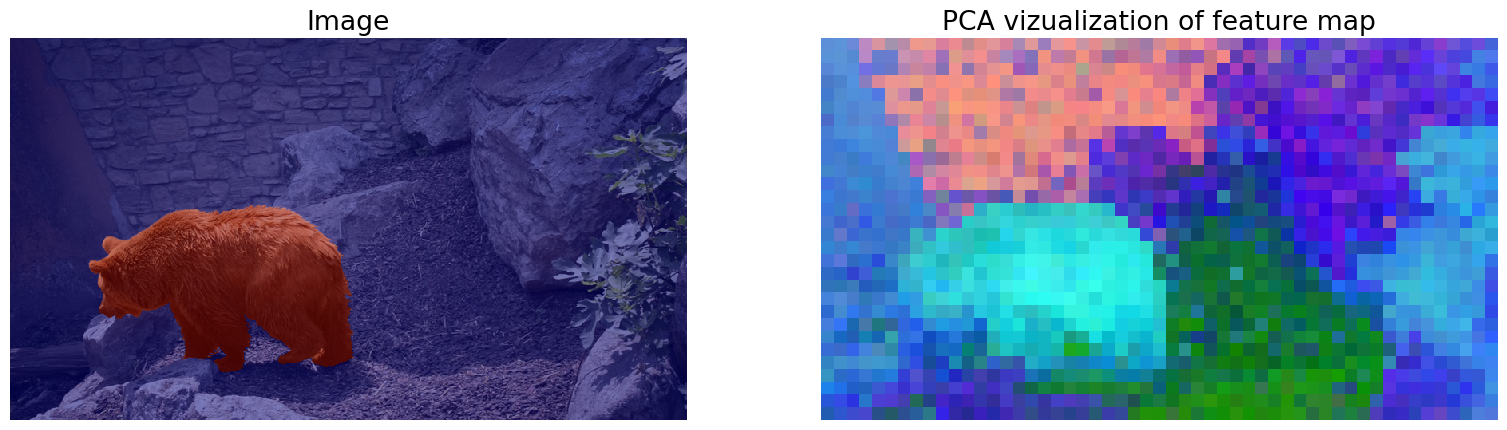

In [8]:
obj_seg_train = ObjectSegmentationDataset(data_dir_obj_seg, split="train")
obj_seg_val = ObjectSegmentationDataset(data_dir_obj_seg, split="val")
obj_seg_test = ObjectSegmentationDataset(data_dir_obj_seg, split="test")

data = obj_seg_train.get_visualization_example(0)
feature_map = data['data']
annotation = data['color_annotations']
img = data['images']

dpi = 96
fig, axs = plt.subplots(1, 2, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
annotation = annotation.mul(255).byte().numpy()
width, height, _ = img.shape
  
axs[0].imshow(img, cmap='gray', interpolation='none')
axs[0].imshow(annotation, cmap='jet', alpha=0.5, interpolation='none')
axs[0].set_title("Image", fontsize=20)
fig.set_size_inches(4 * width / dpi, 2*height / dpi)

feature_map = feature_map
f_width, f_height, _ = feature_map.shape
feature_map = feature_map.flatten(0, -2)
U, S, V = torch.pca_lowrank(feature_map, center=True)
low_rank_feature_map = (feature_map @ V[:, :3]).reshape(f_width, f_height, 3)

for channel in range(3):
  low_rank_feature_map[..., channel] = (low_rank_feature_map[..., channel] - low_rank_feature_map[..., channel].min()) / (low_rank_feature_map[..., channel].max() - low_rank_feature_map[..., channel].min())
low_rank_feature_map = low_rank_feature_map.mul(255).byte().cpu().numpy()

axs[1].imshow(low_rank_feature_map, cmap='gray', interpolation='none')
axs[1].set_title("PCA vizualization of feature map", fontsize=20)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

## Exercise Part I - Decoder Architecture

Given an input image of size $H \times W$ segmentation assigns a label to each pixel of the input image. The resulting 
segmentation masks therefore also has the size $H \times W$. For tasks like image classification or detection spatial 
image information is aggregated by reducing the image resolution with pooling layers in the deeper layers of the neural
network. While the features of the deeper layers contain important high-level information needed for segmentation using
them for segmentation would result in coarse and blocky predictions. It is popular to employ an encoder-decoder
architecture for segmentaton ([example](https://arxiv.org/pdf/1511.00561.pdf)) where the decoder upsamples the
bottleneck layer to the original input size.

Since training a whole encoder-decoder architecture is very expensive and not feasible for this exercise, we will focus
on the decoder part. The input for the decoder network are pretrained [dino](https://arxiv.org/pdf/2104.14294.pdf)
embeddings that encode high-level information for $16 \times 16$ patches using a vision transformer. Therfore, the input 
will not be a $H \times W \times 3$ color images but rather a $H/16 \times W/16 \times 384$ feature tensor. Unlike popular
encoder-decoder architectures, our decoder will not have skip connections for more fine grained information, limiting
the capacity of our network.

Your task is to implement two different upsampling strategies in seperate network architectures, respectively. More
precisely, you will implement:
- upsampling with [interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation#Application_in_image_processing)
- upsamppling as a [sub-pixel convolution](https://arxiv.org/pdf/1609.05158.pdf)
For the interpolation, the type of interpolation is up to you. Popular are *nearest, bilinear, bicubic*

In [9]:
class InterpolationDecoder(nn.Module):
    @staticmethod
    def upsample_with_interpolation(x: torch.Tensor, scale_factor: int = 2) -> torch.Tensor:
        """Upsamples and interpolates the input tensor by a scale factor.

        Args:
            x (torch.Tensor): 4-D feature tensor (B x C x H x W)
            scale_factor (int, optional): upsampling factor to increase spatial resolution. Defaults to 2.

        Returns:
            torch.Tensor: upsampled 4-D feature tensor (B x C x H*scale_factor x W*scale_factor)
        """
        # TASK: Upsample the input tensor of input size (B x C x H x W) to its new spatial resolution (B x C x 2H x 2W).
        # The output tensor should contain interpolated values of the original tensor.
        # OPTIONAL: You can experiment with different scale factors in the network architecture, you have to adapt it
        # accordingly.

        upsampled_and_interpolated = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        # print(type(upsampled_and_interpolated))

        return upsampled_and_interpolated

    def __init__(self, output_classes: int = 1) -> None:
        super().__init__()
        c1, c2, c3 = 64, 32, 16
        self.activation = torch.nn.ReLU()
        if output_classes == 1:
            self.softmax = torch.nn.Sigmoid()
        else:
            self.softmax = torch.nn.Softmax(dim=1)
        self.cnn1 = nn.Conv2d(384, c1, kernel_size=3, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(c1)
        self.cnn2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(c2)
        self.cnn3 = nn.Conv2d(c2, c3, kernel_size=3, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(c3)
        self.cnn4 = nn.Conv2d(c3, output_classes, kernel_size=3, padding=1)

    def forward(self, x):
        """Calculates the forward pass for the decoder architecture

        Args:
            x (torch.Tensor): feature tensor of size (B x C x H/16 x W/16)

        Returns:
            torch.Tensor: output logits of the segmentation mask for N classes of size (B x N x H x W)
        """
        # x = B,C,H/16,W/16
        x = self.activation(self.batch_norm1(self.cnn1(self.upsample_with_interpolation(x))))  # B,C1,H/8,W/8
        x = self.activation(self.batch_norm2(self.cnn2(self.upsample_with_interpolation(x))))  # B,C2,H/4,W/4
        x = self.activation(self.batch_norm3(self.cnn3(self.upsample_with_interpolation(x))))  # B,C2,H/2,W/2
        x = self.softmax(self.cnn4(self.upsample_with_interpolation(x)))  # B,N,H,W
        return x

### Test the interpolation
This cell acts as a sanity check for your interpolation implementation. It checks the implementation with two
simple examples you can look at in `segmentation/utils`. Given that not all possible cases of 
interpolation can be checked, your implementation might fail the following cell but stil be valid.
You need to specify which interpolation you chose, *nearest, bilinear*. We do not check for *bicubic*.

If you implemented *bilinear* interpolation you have to be careful how you aligned your corners. We check for both cases.

In [10]:
from src.segmentation.utils import test_interpolation
test_interpolation(InterpolationDecoder.upsample_with_interpolation, "bilinear")

Shapes are ok.
Values are ok.


In [11]:
class SubPixelConvDecoder(nn.Module):
    @staticmethod
    def upsample_with_subpixel_conv(x: torch.Tensor, scale_factor: int=2) -> torch.Tensor:
        """Upsamples input tensor by a scale factor by using sub-pixel convolution. Sub-pixel convolution assings
        channels to different subpixels to increase spatial resolution.

        Args:
            x (torch.Tensor): 4-D feature tensor (B x scale_factor^2*C x H x W)
            scale_factor (int, optional): upsampling factor to increase spatial resolution. Defaults to 2.

        Returns:
            torch.Tensor: upsampled 4-D feature tensor (B x C x H*scale_factor x W*scale_factor)
        """
        assert x.shape[-3] % scale_factor**2 == 0
        # TASK: Upsample the input tensor of input size (B x 4C x H x W) to its new spatial resolution (B x C x 2H x 2W).
        # The output tensor should contain interpolated values of the original tensor.
        # OPTIONAL: You can experiment with different scale factors in the network architecture, you have to adapt it
        # accordingly.
        sub = nn.PixelShuffle(scale_factor)
        subpixel_conv = sub(x)

        return subpixel_conv

    def __init__(self, output_classes: int = 1) -> None:
        super().__init__()
        c1, c2, c3, c4 = 64, 32, 16, 16
        upsampling_factor = 2**2
        self.activation = torch.nn.ReLU()
        if output_classes == 1:
            self.softmax = torch.nn.Sigmoid()
        else:
            self.softmax = torch.nn.Softmax()
        self.cnn1 = nn.Conv2d(384, upsampling_factor * c1, kernel_size=3, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(upsampling_factor * c1)
        self.cnn2 = nn.Conv2d(c1, upsampling_factor * c2, kernel_size=3, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(upsampling_factor * c2)
        self.cnn3 = nn.Conv2d(c2, upsampling_factor * c3, kernel_size=3, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(upsampling_factor * c3)
        self.cnn4 = nn.Conv2d(c3, upsampling_factor * c4, kernel_size=3, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(upsampling_factor * c4)
        self.cnn5 = nn.Conv2d(c4, output_classes, kernel_size=3, padding=1)

    def forward(self, x):
        """Calculates the forward pass for the decoder architecture

        Args:
            x (torch.Tensor): feature tensor of size (B x C x H/16 x W/16)

        Returns:
            torch.Tensor: output logits of the segmentation mask for N classes of size (B x N x H x W)
        """
        # x = B,C,H/16,W/16
        x = self.upsample_with_subpixel_conv(self.activation(self.batch_norm1(self.cnn1(x))))  # B,C1,H/8,W/8
        x = self.upsample_with_subpixel_conv(self.activation(self.batch_norm2(self.cnn2(x))))  # B,C2,H/4,W/4
        x = self.upsample_with_subpixel_conv(self.activation(self.batch_norm3(self.cnn3(x))))  # B,C2,H/2,W/2
        x = self.upsample_with_subpixel_conv(self.activation(self.batch_norm4(self.cnn4(x))))  # B,C3,H,W
        x = self.softmax(self.cnn5(x))
        return x

### Test the subpixel convolution
This cell acts as a sanity check for your subpixelconvolution implementation. It checks the implementation with two
simple examples you can look at in `segmentation/utils`.

In [12]:
from src.segmentation.utils import test_subconv
test_subconv(SubPixelConvDecoder.upsample_with_subpixel_conv)

Shapes are ok.
Values are ok.


### Train the decoder

We can now train both decoder networks. You can choose between both architectures below. For submission you should only
submit the results of one architecture. You can use the metrics of the validation set to choose the better architecture.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
num_classes = 2
model = SubPixelConvDecoder(1)
# model = InterpolationDecoder(1)
model = model.to(device)

batch_size = 16
dataloader = DataLoader(obj_seg_train, batch_size=batch_size, shuffle=True)

dataloader_valid = DataLoader(obj_seg_val, batch_size=batch_size, shuffle=False)

loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5.0e-4)

def train_epoch(dataloader: DataLoader) -> Dict[str, float]:
    epoch_loss = 0
    model.train()
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad(set_to_none=True)
        feature_maps = data['data'].detach().to(device)
        annotations = data['annotations'].to(device)

        segmentation = model(feature_maps.permute(0, 3, 1, 2))

        loss = loss_func(segmentation[:, 0, ...], annotations)
        epoch_loss += loss.detach().cpu().item() * feature_maps.shape[0]

        loss.backward()
        optimizer.step()

    metrics: Dict[str, float] = {}
    metrics['loss'] = epoch_loss
    return metrics

def eval_epoch(dataloader: DataLoader) -> float:
    epoch_loss = 0
    model.eval()
    conf_matrix = torch.zeros(num_classes, num_classes)
    for data in dataloader:
        feature_maps = data['data'].to(device)
        annotations = data['annotations'].to(device)

        segmentation = model(feature_maps.permute(0, 3, 1, 2))

        loss = loss_func(segmentation[:, 0, ...], annotations)
        epoch_loss += loss.detach().cpu().item() * feature_maps.shape[0]

        labels = binary_output_to_labels(segmentation[:, 0, ...])
        conf_matrix = conf_matrix + confusion_matrix(labels, annotations, num_classes).detach().cpu()

    metrics: Dict[str, float] = {}
    metrics['loss'] = epoch_loss
    metrics['acc'] = accuracy(conf_matrix)
    metrics['m_prcn'] = mean_precision(conf_matrix)
    metrics['m_rcll'] = mean_recall(conf_matrix)
    metrics['m_iou'] = mean_iou(conf_matrix)
    return metrics

metrics_header()
num_epochs = 5
for epoch in range(5):
    metrics_train = train_epoch(dataloader)
    print_metrics(metrics_train, epoch, "train")
    if (epoch % 5 == 0) or (epoch + 1 == num_epochs):
        metrics_val = eval_epoch(dataloader_valid)    
        print_metrics(metrics_val, epoch, "val")

torch.save(model, model_dir.joinpath('object_segmentation_model.pth'))

cuda
   Epoch      Split   Loss   Acc mPrcn mRcll  mIOU
       0      train  94.37     -     -     -     -
       0        val  38.30  0.91  0.75  0.92  0.69
       1      train  72.54     -     -     -     -
       2      train  58.45     -     -     -     -
       3      train  46.65     -     -     -     -
       4      train  36.94     -     -     -     -
       4        val  17.55  0.97  0.91  0.93  0.86


### Visualization of the results
You can check the performance of the model by selecting either the test, val, or test set. For the test set no ground
truth annotations are provided.

Select the different sets with one of the following lines

```
viz_dataset = obj_seg_train
viz_dataset = obj_seg_val
viz_dataset = obj_seg_test
```

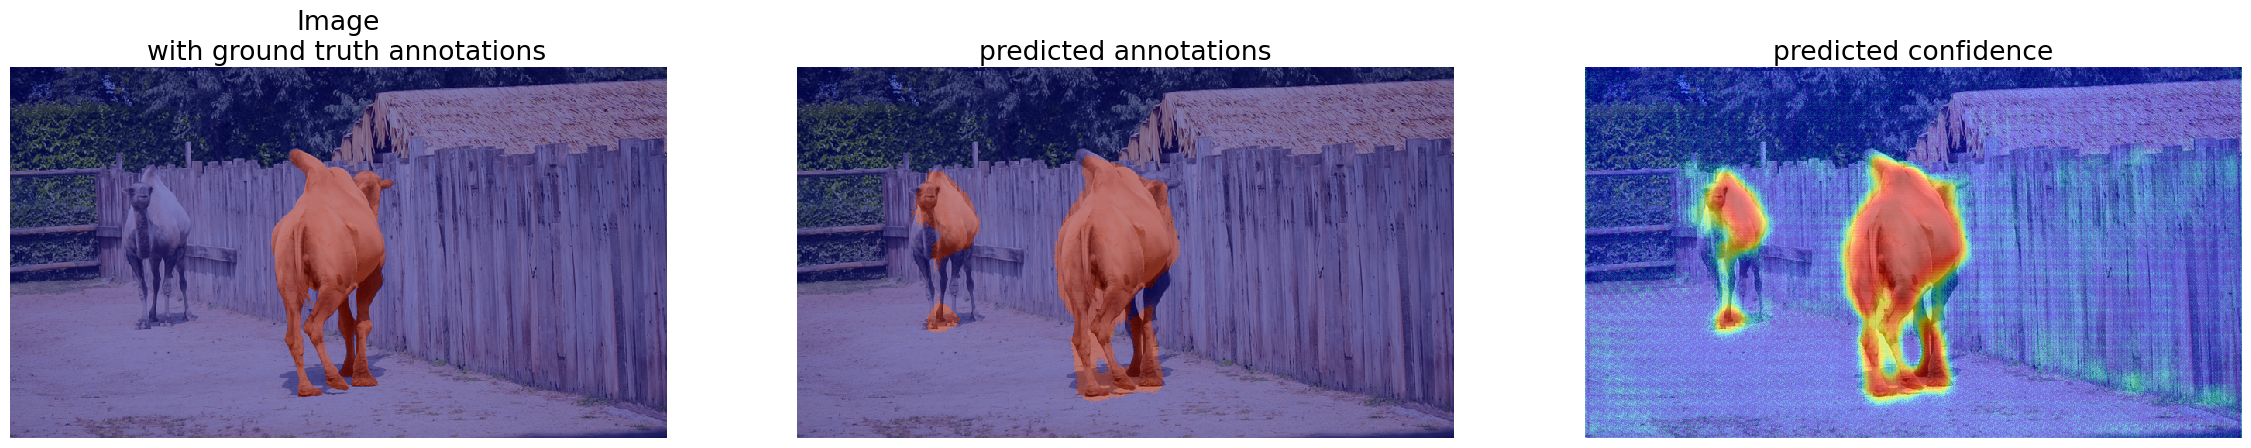

In [ ]:
# You can test the performance on the datasets for unsupervised segmentation and see that the model has not generalized
# to non-animals
# viz_dataset = ObjectSegmentationDataset(data_dir_obj_seg, "unsupervised_0")
viz_dataset = obj_seg_val
data = viz_dataset.get_visualization_example(0)
feature_maps = data['data'][None].to(device)
img = data['images']

dpi = 96
fig, axs = plt.subplots(1, 3, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape
axs[0].imshow(img, cmap='gray', interpolation='none')
title = "Image"
  
if not viz_dataset.no_gt:
  annotation = data['color_annotations']
  annotation = annotation.mul(255).byte().numpy()
  axs[0].imshow(annotation, cmap='jet', alpha=0.5, interpolation='none')
  title += "\n  with ground truth annotations"
axs[0].set_title(title, fontsize=20)
fig.set_size_inches(6 * width / dpi, 2 *height / dpi)

model.eval()
segmentation = model(feature_maps.permute(0, 3, 1, 2))
labels = binary_output_to_labels(segmentation)
segmentation = segmentation[0, 0].mul(255).byte().cpu().numpy()
labels = labels[0, 0].byte().cpu().numpy()
axs[1].imshow(img, cmap='gray', interpolation='none')
axs[1].imshow(labels, cmap='jet', alpha=0.5, interpolation='none')
axs[1].set_title("predicted annotations", fontsize=20)

axs[2].imshow(img, cmap='gray', interpolation='none')
axs[2].imshow(segmentation, cmap='jet', alpha=0.5, interpolation='none')
axs[2].set_title("predicted confidence", fontsize=20)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

### Creating the test-set outputs

In [ ]:
# Write Output for Test set
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 16
model_path = model_dir.joinpath('object_segmentation_model.pth')
load_model = True
if load_model:
    # model = InterpolationDecoder(1)
    model = torch.load(model_path)

dataloader_test = DataLoader(obj_seg_test, batch_size=batch_size, shuffle=False)
model.eval()
segmentation_images = []
for batch_idx, data in enumerate(dataloader_test):
    feature_maps = data['data'].to(device)

    labels = binary_output_to_labels(model(feature_maps.permute(0, 3, 1, 2)))[:, 0]
    for img in labels:
        segmentation_images.append(img)

assert len(segmentation_images) == 60

for idx, img in enumerate(segmentation_images):
    save_image(img, output_dir.joinpath('obj_seg', f'{idx:05d}.png'))

# Semantic segmentation dataset

The CamVid (Cambridge-driving Labeled Video Database) is a collection of videos with class semantic labels. In the 
original, the dataset has 32 semantic classes, however we will train on a subset of the dataset with reduced
annotations of 9 custom classes. This allows for a smaller network architecture and still produce good looking results.

See the [webpage](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) for further examples.

In the following, we show examples for different video sequences with their respective ground truth annotations.

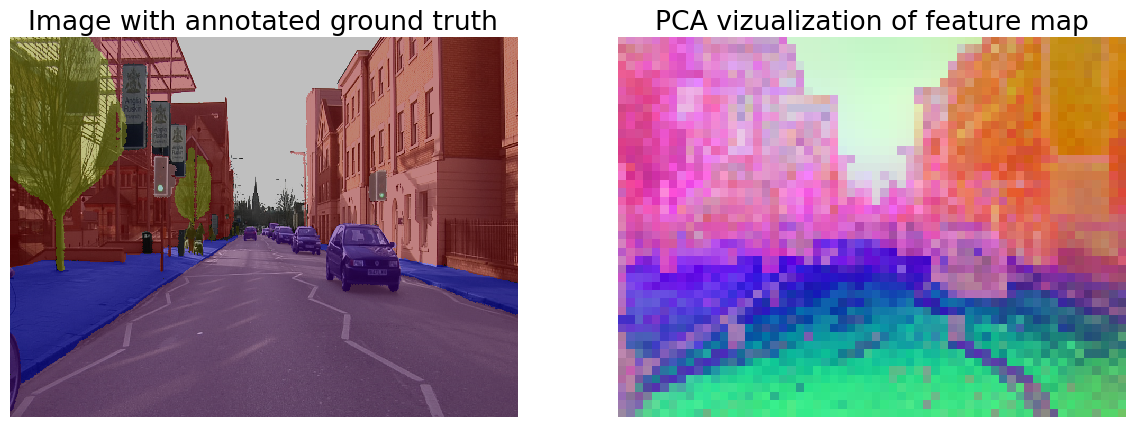

In [15]:
sem_seg_train = SemanticSegmentationDataset(data_dir_sem_seg, split="train")
sem_seg_val = SemanticSegmentationDataset(data_dir_sem_seg, split="val")
sem_seg_test = SemanticSegmentationDataset(data_dir_sem_seg, split="test")

data = sem_seg_train.get_visualization_example(0)
feature_map = data['data']
annotation = data['color_annotations']
img = data['images']

dpi = 96
fig, axs = plt.subplots(1, 2, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
annotation = annotation.permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape
  
axs[0].imshow(img, cmap='gray', interpolation='none')
axs[0].imshow(annotation, cmap='jet', alpha=0.5, interpolation='none')
axs[0].set_title("Image with annotated ground truth", fontsize=20)
fig.set_size_inches(2 * width / dpi, height / dpi)

feature_map = feature_map
f_width, f_height, _ = feature_map.shape
feature_map = feature_map.flatten(0, -2)
U, S, V = torch.pca_lowrank(feature_map, center=True)
low_rank_feature_map = (feature_map @ V[:, :3]).reshape(f_width, f_height, 3)

for channel in range(3):
  low_rank_feature_map[..., channel] = (low_rank_feature_map[..., channel] - low_rank_feature_map[..., channel].min()) / (low_rank_feature_map[..., channel].max() - low_rank_feature_map[..., channel].min())
low_rank_feature_map = low_rank_feature_map.mul(255).byte().cpu().numpy()

axs[1].imshow(low_rank_feature_map, cmap='gray', interpolation='none')
axs[1].set_title("PCA vizualization of feature map", fontsize=20)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

## Exercise Part II - Class Imbalance

We can reuse the same decoder architectures for sementic segmentation as well. In the following, you will retrain the 
network architectures to do semantic segmentation on a driving dataset. However, naivly adapting the training setup will
result in bad results. This is due to a class imbalance in the dataset. Not all classes are equally likely to appear in the images, e.g. cars vs. pedastrians in the segmentation dataset. Using a normal cross entropy loss leads to a large bias of the network to classes that cover large regions of the image. Smaller classes like pedestrians will be ignored. 

To addres this one can use the weighted [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), with individual weights to each class. Your task is to find suitable weights for each class for the given dataset.

One possible weighting is given by

$ w_i = \frac{\sum_j N_j}{c \cdot N_i}\,,$

where $N_i$ counts the number of pixels of class $i$ over the whole training set and $c$ is an appropriate constant, e.g. $2$.

Your task is, given the dataset, find appropriate weights for each class to balance the training classes.

In [45]:
def class_weights(dataloader: DataLoader, num_classes: int = 9) -> torch.Tensor:
    """Calculate weights for the cross entropy loss to address class imbalance in the dataset.

    Args:
        dataloader (DataLoader): pytorch dataloader containing the CamVid dataset training split with ground truth 
        annotations
        num_classes (int, optional): Number of classes in the dataset. Defaults to 9.

    Returns:
        torch.Tensor: tensor of size (num_classes) containing weights for the individual classes.
    """
    # TASK: From the dataset, caclulate appropriate weights for each class. One possibility for weights is given above.
    # However, you might be able to find better ones by exerimenting.
    # HINT: You can iterate over the dataloader and access the ground truth annontations using
    nums = torch.zeros(num_classes)
    # print(nums)
    for data in dataloader:
        annotations = data["annotations"]
        # print(torch.numel(annotations))
        # print((annotations==0).sum())
        # print()
        # print(annotations.size())
        for i in range(num_classes):
          # print(nums[i])
          nums[i] = torch.add(nums[i],(annotations==i).sum())
          # print((annotations==i).sum())
    # print(torch.sum(nums))
    # print(nums[i])
    weights = 0.5* torch.div(torch.sum(nums),nums)
    
    return weights

### Calculate class weights

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 8
num_classes = 9
dataloader = DataLoader(sem_seg_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(sem_seg_val, batch_size=batch_size, shuffle=False)

weights = class_weights(dataloader, num_classes).to(device)
assert weights.shape == (9, )

In [47]:
weights

tensor([  1.7320,  62.8126,  11.9805,   1.7547, 100.6956,   9.2601,   3.6227,
          7.4156,   4.4539], device='cuda:0')

### Train the decoder

As previously, we can now train both decoder networks. You can choose between both architectures below. For submission you should only
submit the results of one architecture. You can use the metrics of the validation set to choose the better architecture.

In [48]:
# model = SubPixelConvDecoder(num_classes)
model = InterpolationDecoder(num_classes)
model = model.to(device)

loss_func = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=3.0e-4)

def train_epoch(dataloader: DataLoader) -> Dict[str, float]:
    epoch_loss = 0
    model.train()
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad(set_to_none=True)
        feature_maps = data['data'].to(device)
        annotations = data['annotations'].to(device)

        segmentation = model(feature_maps.permute(0, 3, 1, 2))

        loss = loss_func(segmentation.permute(0, 2, 3, 1).flatten(0, 2), annotations.flatten(0, 2))
        epoch_loss += loss.detach().cpu().item() * feature_maps.shape[0]

        loss.backward()
        optimizer.step()

    metrics: Dict[str, float] = {}
    metrics['loss'] = epoch_loss
    return metrics

def eval_epoch(dataloader: DataLoader) -> float:
    epoch_loss = 0
    model.eval()
    conf_matrix = torch.zeros(num_classes, num_classes)
    for data in dataloader:
        optimizer.zero_grad(set_to_none=True)
        feature_maps = data['data'].to(device)
        annotations = data['annotations'].to(device)

        segmentation = model(feature_maps.permute(0, 3, 1, 2))

        loss = loss_func(segmentation.permute(0, 2, 3, 1).flatten(0, 2), annotations.flatten(0, 2))
        epoch_loss += loss.detach().cpu().item() * feature_maps.shape[0]

        labels = logits_to_labels(segmentation)
        conf_matrix = conf_matrix + confusion_matrix(labels, annotations, num_classes).detach().cpu()

    metrics: Dict[str, float] = {}
    metrics['loss'] = epoch_loss
    metrics['acc'] = accuracy(conf_matrix)
    metrics['m_prcn'] = mean_precision(conf_matrix)
    metrics['m_rcll'] = mean_recall(conf_matrix)
    metrics['m_iou'] = mean_iou(conf_matrix)
    return metrics

metrics_header()
num_epochs = 15
for epoch in range(num_epochs):
    metrics_train = train_epoch(dataloader)
    print_metrics(metrics_train, epoch, "train")
    if (epoch % 5 == 0) or (epoch + 1 == num_epochs):
        metrics_val = eval_epoch(dataloader_valid)    
        print_metrics(metrics_val, epoch, "val")

torch.save(model, model_dir.joinpath('semantic_segmentation_model.pth'))

   Epoch      Split   Loss   Acc mPrcn mRcll  mIOU
       0      train 308.06     -     -     -     -
       0        val  97.65  0.32  0.56  0.47  0.17
       1      train 288.93     -     -     -     -
       2      train 278.95     -     -     -     -
       3      train 270.21     -     -     -     -
       4      train 262.53     -     -     -     -
       5      train 256.76     -     -     -     -
       5        val  84.40  0.81  0.70  0.79  0.52
       6      train 251.12     -     -     -     -
       7      train 245.82     -     -     -     -
       8      train 242.00     -     -     -     -
       9      train 238.72     -     -     -     -
      10      train 235.52     -     -     -     -
      10        val  78.79  0.87  0.71  0.84  0.62
      11      train 231.87     -     -     -     -
      12      train 229.04     -     -     -     -
      13      train 227.52     -     -     -     -
      14      train 225.77     -     -     -     -
      14        val  76.52  0.8

### Visualization of the results
You can check the performance of the model by selecting either the test, val, or test set. For the test set no ground
truth annotations are provided.

Select the different sets with one of the following lines

```
viz_dataset = sem_seg_train
viz_dataset = sem_seg_val
viz_dataset = sem_seg_test
```

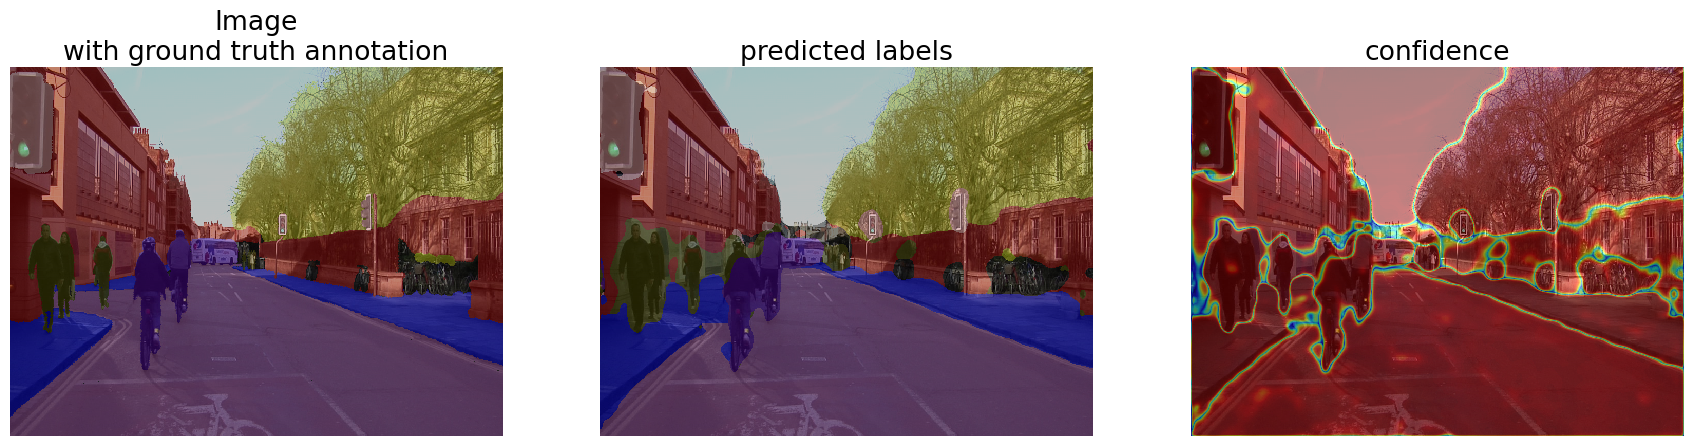

In [49]:
viz_dataset = sem_seg_val
data = viz_dataset.get_visualization_example(0)
feature_maps = data['data'][None].to(device)
img = data['images']

dpi = 96
fig, axs = plt.subplots(1, 3, dpi=dpi)

img = img.mul(255).permute(1, 2, 0).byte().numpy()
width, height, _ = img.shape
axs[0].imshow(img, cmap='gray', interpolation='none')
title = "Image"
  
if not viz_dataset.no_gt:
  annotation = data['color_annotations'].permute(1, 2, 0)
  annotation = annotation.byte().numpy()
  axs[0].imshow(annotation, cmap='jet', alpha=0.5, interpolation='none')
  title += "\nwith ground truth annotation"
axs[0].set_title(title, fontsize=20)
fig.set_size_inches(3 * width / dpi, height / dpi)


model.eval()
segmentation = model(feature_maps.permute(0, 3, 1, 2))
labels = logits_to_labels(segmentation)
color_labels = labels_to_color(labels[0], sem_seg_train.class_dict)
max_conf = segmentation[0].max(dim=0)[0].mul(255).byte().cpu().numpy()
color_labels = color_labels.permute(1, 2, 0).byte().cpu().numpy()
axs[1].imshow(img, cmap='gray', interpolation='none')
axs[1].imshow(color_labels, cmap='jet', alpha=0.5, interpolation='none')
axs[1].set_title("predicted labels", fontsize=20)

axs[2].imshow(img, cmap='gray', interpolation='none')
axs[2].imshow(max_conf, cmap='jet', alpha=0.5, interpolation='none')
axs[2].set_title("confidence", fontsize=20)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

### Creating the test-set outputs

In [50]:
# evaluate training set
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 1
model_path = model_dir.joinpath('semantic_segmentation_model.pth')
load_model = True
if load_model:
    model = torch.load(model_path)

dataloader_test = DataLoader(sem_seg_test, batch_size=batch_size, shuffle=False)
model.eval()
segmentation_images = []
for batch_idx, data in enumerate(dataloader_test):
    feature_maps = data['data'].to(device)

    labels = logits_to_labels(model(feature_maps.permute(0, 3, 1, 2)))
    for label_img in labels:
        segmentation_images.append(labels_to_color(label_img, sem_seg_train.class_dict) / 255.0)

assert len(segmentation_images) == 50

for idx, img in enumerate(segmentation_images):
    save_image(img, output_dir.joinpath('sem_seg', f'{idx:05d}.png'))

## Exercise Part III - Clustering

Obtaining ground truth annotations for semantic segmentation is often expensive. However, there are wast amounts of
unlabeld data. In the following, we will explore how to obtain still decent object segmentation masks using unsupervised
training with a simple algorithm such as [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). With
the dino features, we already have powerful embeddings containing high level information in the images. 

Your task is to implement k-means clustering on the dino features to generate segmentation masks for classes without
ground truth annotations. While you are free to choose the distance metric for the clustering we recommend you use the 
$L_2$ norm, also known as the euclidean distance. If you choose a different distance metric you need to adapt the 
center calculation accordingly.

In [63]:
def distance_to_centers(points: torch.Tensor, centers: torch.Tensor) -> torch.Tensor:
    """For each datapoint, calculate its distance to each cluster center.

    Args:
        points (torch.Tensor): 2-D feature tensor (N x C) of N datapoints of size C
        centers (torch.Tensor): 2-D feature tensor (K x C) of K clusters centers

    Returns:
        torch.Tensor: distance tensor (N x K) of the N datapoints to the K center points
    """
    # TASK: Calculate the distance tensor of size N x K between all N elements and all K elements. Each elements is a 
    # feat-D vector. The entry i,j of the distance matrix gives the distance of datapoint i to center j.
    N,C = points.size()
    K,_ = centers.size()
    t1 = points.unsqueeze(1).expand(N,K,C)
    t2 = centers.unsqueeze(0).expand(N,K,C)
    # print(t1)
    # print(t2)
    distances = (t1 - t2).pow(2).sum(2)
    # print(distances)

    return distances

In [64]:
def assign_cluster(distances: torch.Tensor) -> torch.Tensor:
    """Assign the cluster to each datapoint based on the distances to the centers.

    Args:
        distances (torch.Tensor): 2-D feature tensor (N x K) of distances

    Returns:
        torch.Tensor: cluster labels (N) giving the cluster with minimum distance for each of the N datapoints
    """
    # TASK: Assign the cluster number 0..K-1 to each datapoint based on which cluster has the minimum distance.
  
    
    assignments = torch.argmin(distances, dim=1, keepdim=False)
    # print(assignments)

    return assignments

In [65]:
def calculate_centers(points: torch.Tensor, assignments: torch.Tensor, num_centers: int) -> torch.Tensor:
    """Calculate the new center points of the clusters based on the assignments

    Args:
        points (torch.Tensor): 2-D feature tensor (N x C) of N datapoints of size C
        assignments (torch.Tensor): 1-D feature tensor (N) containing the cluster assignments for each datapoint
        num_centers (int): number on clusters

    Returns:
        torch.Tensor: new cluster center tensor (K, C)
    """
    # TASK: Calculate the new center points based on the assignments. Caluclation of the new optimal center points is 
    # denpendent on the distance metric used for assignment. For the euclidean distance it is the mean value.
    centers =[]
    # print(num_centers)
    # print( points.size())
    for i in range(num_centers):
      b = torch.nonzero(assignments==i).squeeze()
      x = points.index_select(0, b).mean(dim=0)
      x = x.unsqueeze(0)
      centers.append(x)
    
    centers = torch.cat(centers,0)
    # print(centers.size())
    return centers

### Do k-Means Clustering
For both example datasets, cluster the image regions based on feature similarity.

*Optional Task*: You can experiment with a different number of classes and check the visualization below to see what 
works best. You can submit your results with any number of classes. The performance is measured to the cluster with the
highest overlap with the object. Therefore, to few classes will assign other parts of the image to the object cluster, 
whilst to many classes will split the object into multiple clusters.

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clustering_datasets = []
clustering_datasets = [ObjectSegmentationDataset(data_dir_obj_seg, split=f"unsupervised_{idx}") for idx in range(2)]
centers_list = []
for idx, dataset in enumerate(clustering_datasets):
    dataloader = DataLoader(dataset, batch_size=len(dataset), drop_last=False)

    n_classes = 4

    centers = torch.rand(n_classes, 384).to(device)

    data = next(iter(dataloader))
    features = data['data'].flatten(0, -2).to(device) # B*H*W,C
    print(f"Loss for dataset {idx}")
    for epoch in range(100):
        distances = distance_to_centers(features, centers)
        epoch_loss = torch.min(distances, dim=-1)[0].sum()

        assignments = assign_cluster(distances)
        centers = calculate_centers(features, assignments, n_classes)

        if epoch % 10 == 0:
            print(f"{f'Epoch {epoch} Loss:' : >20} {epoch_loss}")

    centers_list.append(centers.detach().cpu())

Loss for dataset 0
       Epoch 0 Loss: 360099488.0
      Epoch 10 Loss: 260550528.0
      Epoch 20 Loss: 260427008.0
      Epoch 30 Loss: 260426800.0
      Epoch 40 Loss: 260426800.0
      Epoch 50 Loss: 260426800.0
      Epoch 60 Loss: 260426800.0
      Epoch 70 Loss: 260426800.0
      Epoch 80 Loss: 260426800.0
      Epoch 90 Loss: 260426800.0
Loss for dataset 1
       Epoch 0 Loss: 327143296.0
      Epoch 10 Loss: 152076208.0
      Epoch 20 Loss: 152074464.0
      Epoch 30 Loss: 152074464.0
      Epoch 40 Loss: 152074464.0
      Epoch 50 Loss: 152074464.0
      Epoch 60 Loss: 152074464.0
      Epoch 70 Loss: 152074464.0
      Epoch 80 Loss: 152074464.0
      Epoch 90 Loss: 152074464.0


### Visualization of the results

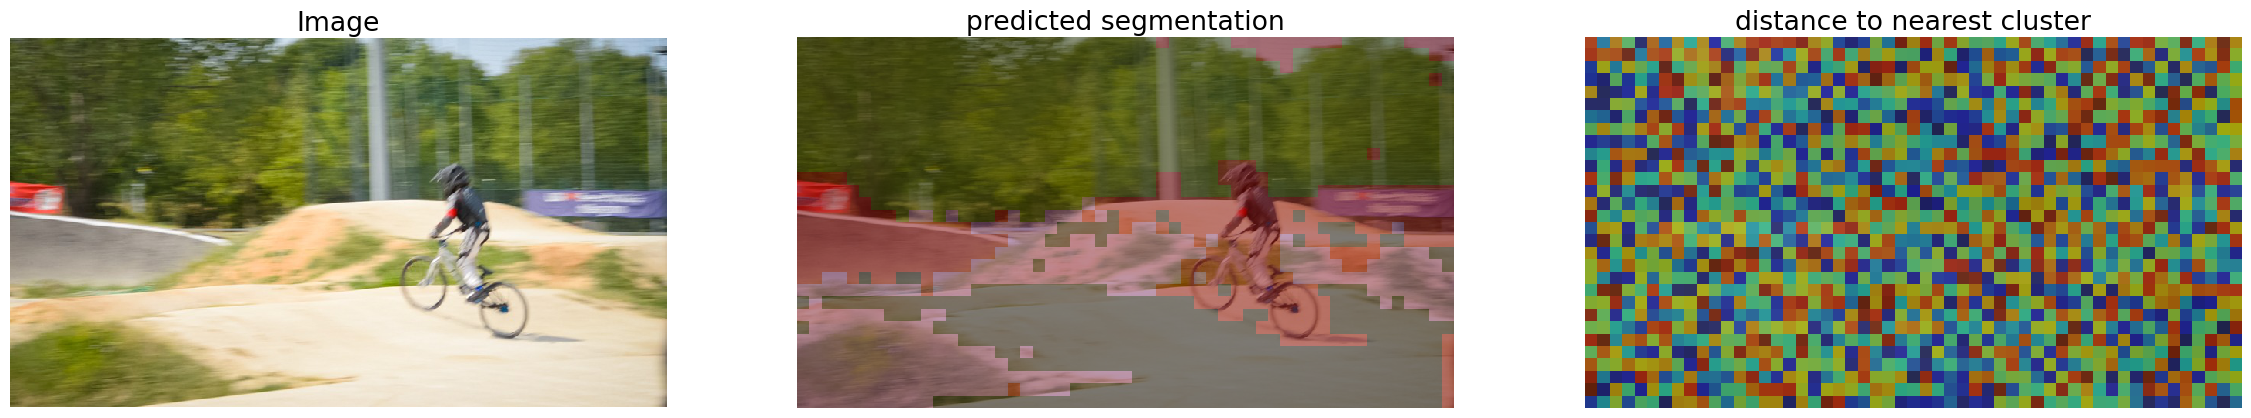

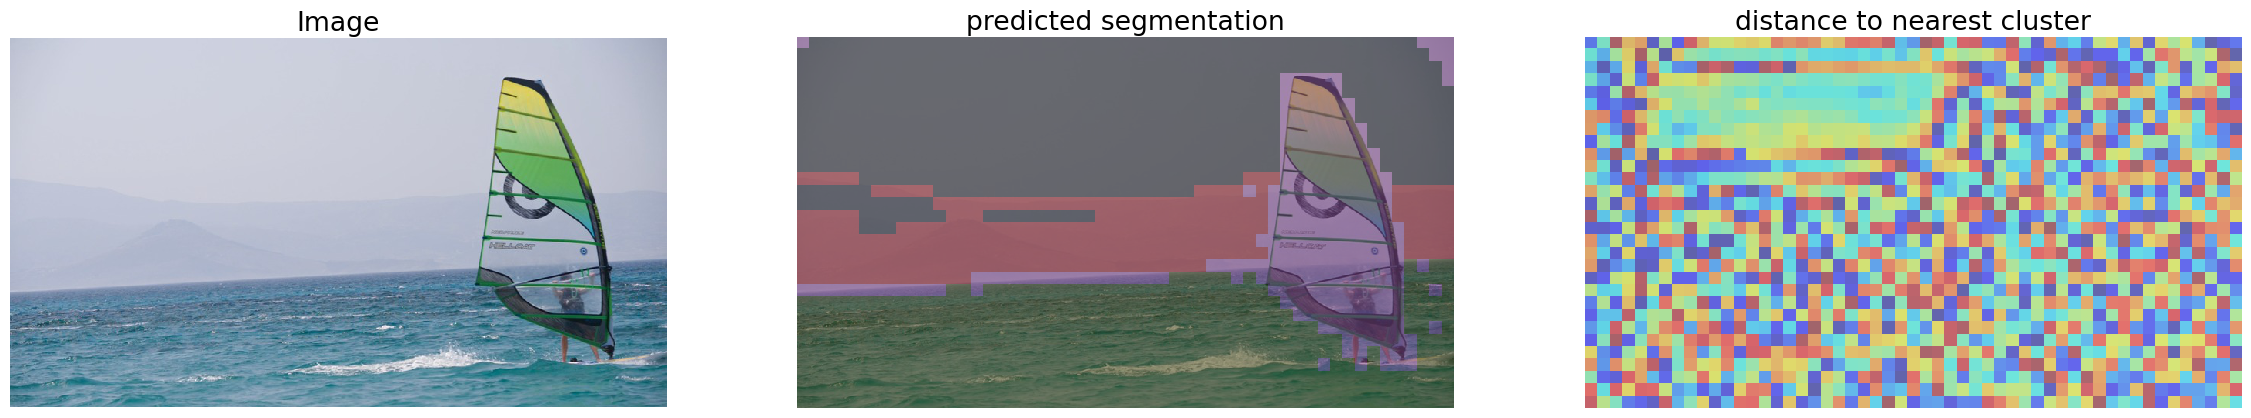

In [67]:
# if you use more than 9 clusters, expand this dict with more rgb-values
class_dict = {
                (128,0,0): (0, "0"),
                (64,64,0): (1, "1"),
                (0,0,0): (2, "2"),
                (128,64,128): (3, "3"),
                (192,128,128): (4, "4"),
                (0,0,192): (5, "5"),
                (128,128,128): (6, "6"),
                (64,0,128): (7, "7"),
                (128,128,0): (8, "8")
            }
for idx, (dataset, centers) in enumerate(zip(clustering_datasets, centers_list)):
    data = dataset.get_visualization_example(0)

    features = data['data'].flatten(0, -2).to(device) # B*H*W,C
    img = data['images']

    dpi = 96
    fig, axs = plt.subplots(1, 3, dpi=dpi)

    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    width, height, _ = img.shape
    axs[0].imshow(img, cmap='gray', interpolation='none')
    axs[0].set_title("Image", fontsize=20)
    fig.set_size_inches(6 * width / dpi, 2*height / dpi)

    distances = distance_to_centers(features, centers.to(device))
    min_distances = torch.min(distances, dim=-1)[0].reshape(data['data'].shape[:-1]).cpu().byte().numpy()
    assignments = assign_cluster(distances)

    assignments = assignments.reshape(data['data'].shape[:-1])
    assignments = nn.Upsample(scale_factor=16, mode="nearest")(assignments[None, None].to(torch.float32))[0, 0]
    color_assignments = labels_to_color(assignments, class_dict).permute(1, 2, 0).cpu().byte().numpy()

    axs[1].imshow(img, cmap='gray', interpolation='none')
    axs[1].imshow(color_assignments, cmap='jet', alpha=0.5, interpolation='none')
    axs[1].set_title("predicted segmentation", fontsize=20)

    axs[2].imshow(img, cmap='gray', interpolation='none')
    axs[2].imshow(min_distances, cmap='jet', alpha=0.5, interpolation='none')
    axs[2].set_title("distance to nearest cluster", fontsize=20)


    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

### Creating the test-set outputs

In [68]:
for idx, (dataset, centers) in enumerate(zip(clustering_datasets, centers_list)):
    obj_seg_dataset = ObjectSegmentationDataset(data_dir_obj_seg, split=f"unsupervised_{idx}")
    dataloader = DataLoader(obj_seg_dataset, batch_size=len(obj_seg_dataset), drop_last=False)
    data = next(iter(dataloader))
    features = data['data'].flatten(0, -2).to(device) # B*H*W,C

    distances = distance_to_centers(features, centers.to(device))
    assignments = assign_cluster(distances)

    assignments = assignments.reshape(data['data'].shape[:-1])
    assignments = nn.Upsample(scale_factor=16, mode="nearest")(assignments[None].to(torch.float32))[0]

    segmentation_images = []
    for assignment in assignments:
        segmentation_images.append(labels_to_color(assignment, class_dict))

    assert len(segmentation_images) == 30
    for img_idx, img in enumerate(segmentation_images):
        save_image(img, output_dir.joinpath(f'clust_{idx}', f'{img_idx:05d}.png'))